In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import random
import math

from numpy import mean, std
from scipy import stats
import scipy as sp
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import get_scorer, make_scorer, confusion_matrix, classification_report, recall_score, precision_score, accuracy_score, fbeta_score, roc_curve, roc_auc_score, f1_score, confusion_matrix, mean_squared_error, log_loss
from sklearn import svm, datasets
from sklearn.naive_bayes import BernoulliNB
from sklearn.datasets import make_classification
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import BernoulliNB

from warnings import simplefilter
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer

simplefilter("ignore", category = ConvergenceWarning)

In [33]:
class KidronClassifier:
    
    def __init__(self, min_rows = None, min_columns = None, max_estimators = None, estimators = None, base_estimator = None, random_state = None):

        self.min_rows = min_rows
        self.min_columns = min_columns
        self.max_estimators = max_estimators
        self.estimators = estimators
        self.base_estimator = base_estimator 
        self.random_state = random_state 
        #self.fitted_estimators = None
        #self.fitted_columns = None        
        return
             
    def get_params(self, deep = True):
        return {"min_rows": self.min_rows, 
                "min_columns": self.min_columns,
                "max_estimators": self.max_estimators,
                "estimators": self.estimators,
                "base_estimator": self.base_estimator,
                "random_state": self.random_state}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    #build training data for a single model
    def even_data(self, dict_X, length, width, seed):     
        
        labels = dict_X.keys()          
        X = pd.concat([dict_X[label].sample(n = length, random_state = seed) for label in labels]) #length
        
        random.seed(seed)
        columns = random.sample(range(len(X.columns)), width)
        X = X.iloc[:, columns]
        
        y = []
        for label in labels:
            y.extend([label] * length)
        
        return X, y, columns

    #fit 
    def fit(self, X, y):

        #label encoding
        self.le = LabelEncoder()
        self.le.fit(y)
        
        #X = pd.DataFrame(X)
        
        length = X.shape[0] #len(X);
        width  = X.shape[1] #len(X.columns)
        col = min([int(width  ** 0.5) + 1, width])
        row = min([int(length ** 0.5) + 1, length])            
        estimators = row * col
        
        if(self.max_estimators):
            estimators = min([estimators, self.max_estimators])
            
        if(self.estimators is None):
            if(self.base_estimator):
                self.estimators = [clone(self.base_estimator) for i in range(estimators)]
            else:
                self.estimators = [LogisticRegression() for i in range(estimators)]  #default
                                
        dict_X = {}
        for label in self.le.classes_:
            dict_X[label] = X[y == label]
            
        rows = min([len(dict_X[label]) for label in dict_X.keys()])  #maximal length available  
        rows = min(row, length)
        if(self.min_rows):
            rows = max([self.min_rows, rows])
            
        cols = col
        if(self.min_columns):
            cols = max([self.min_columns, cols])
        
        seed, self.fitted_estimators, self.fitted_columns = 0, [], []
        #print(len(self.estimators))
        
        for estimator in self.estimators:

            #get a balanced data
            X_train, y_train, fitted_columns = self.even_data(dict_X, rows, cols, seed)
            
            #fit
            fitted_estimator = estimator.fit(X_train, y_train)
            
            #save fitted
            self.fitted_estimators.append(fitted_estimator)
            self.fitted_columns.append(fitted_columns)
            
            seed += 1
        return
    
    #predict_proba
    def predict_proba(self, X):

        length = len(X)
        labels = len(self.le.classes_)
        
        pred = []
        
        # Predict 'soft' voting with probabilities
        predict_proba = []
        for fitted_estimator, fitted_columns in zip(self.fitted_estimators, self.fitted_columns):             
            fitted_X = X.iloc[:, fitted_columns]
            predict_proba.append(np.asarray(fitted_estimator.predict_proba(fitted_X)).reshape(length * labels, 1))
            
        predict_proba = np.concatenate(predict_proba, axis = 1)
        predict_proba = np.average(predict_proba, axis = 1).reshape(length, labels)
            
        # Convert integer predictions to original labels:
        return predict_proba
    
    #predict
    def predict(self, X):
            
        proba = self.predict_proba(X)
        
        # Convert integer predictions to original labels:
        return self.le.inverse_transform(np.argmax(proba, axis = 1))
    
    #predict, old slow version
    def predict_slow(self, X):

        pred = []
        for i in range(len(X)):

            # Predict 'soft' voting with probabilities
            x = X[i : i + 1]
            predict_proba = np.asarray([estimator.predict_proba(x) for estimator in self.fitted_estimators])
            predict_proba = np.average(predict_proba, axis = 0)
        
            #the indice of the average
            pred.append(np.argmax(predict_proba, axis = 1)[0])        

        # Convert integer predictions to original labels:
        return self.le.inverse_transform(pred)

In [2]:
path = "/Users/yaeerk/Documents/NAYA/classification/"
jobs = 8

In [3]:
df = pd.read_csv(path + 'PROTECT_and_RISK_shared_DEGs_NOT NORM.csv', index_col = 0)
X = df.drop('Diagnosis', axis = 1)
y = df.Diagnosis
y = LabelEncoder().fit_transform(y)
numerical_cols = X.columns.to_list()

In [4]:
#results1 = pd.read_csv(path + "classification-results-1.csv")
#results2 = pd.read_csv(path + "classification-results-2.csv")
#results = pd.concat([results1, results2], axis = 0)

results = pd.read_csv(path + "classification-results-3.csv")
#results = pd.read_csv(path + "classification-results-4-shrink-50.csv")
results.tail()

,Unnamed: 0,score,test score,train score,test variance,train variance,test rmse,train rmse,test log_loss,train log_loss,test size,random state,estimator,estimator params
331,331,accuracy,0.979585,0.996811,0.000299,0.000008,0.175412,0.071429,1.062744,1.762182e-01,0.2,1250,Smote/Bagging/SVC,"True,False,10,1.0,linear,1"
332,332,f1,0.985062,1.000000,0.000088,0.000000,0.248069,0.000000,2.125500,9.992007e-16,0.2,1850,Smote/Bagging/SVC,"False,False,2,1.0,linear,1"
333,333,accuracy,0.985366,1.000000,0.000083,0.000000,0.248069,0.000000,2.125500,9.992007e-16,0.2,1850,Smote/Bagging/SVC,"False,False,2,1.0,linear,1"
334,334,f1,0.975831,0.998028,0.000339,0.000007,0.124035,0.000000,0.531366,9.992007e-16,0.2,2050,Smote/Bagging/SVC,"False,True,10,0.6,linear,1"
335,335,accuracy,0.976623,0.992187,0.000499,0.000020,0.124035,0.072169,0.531366,1.798895e-01,0.2,2050,Smote/Bagging/SVC,"True,False,10,0.8,linear,1"


In [5]:
results.estimator.unique()

array(['Smote/RandomForestClassifier', 'KidronClassifier',
       'Smote/Bagging/LogisticRegression', 'Smote/Bagging/SVC'],
      dtype=object)

In [6]:
f1       = results[results.score == "f1"]
accuracy = results[results.score == "accuracy"]

<AxesSubplot:xlabel='test score', ylabel='test log_loss'>

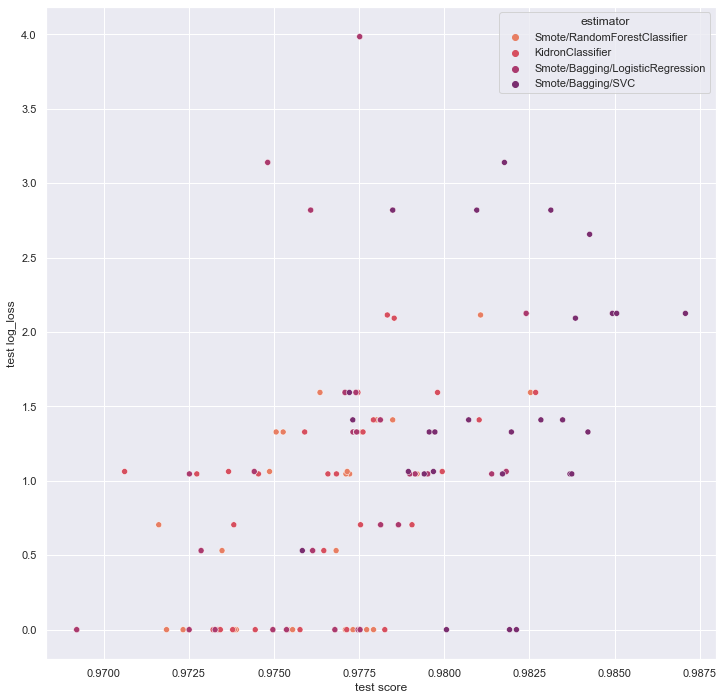

In [7]:
sns.set(rc = {"figure.figsize" : (12, 12)}) 
sns.scatterplot(data = f1, x = "test score", y = "test log_loss", hue = "estimator", palette = "flare")

<AxesSubplot:xlabel='test score', ylabel='random state'>

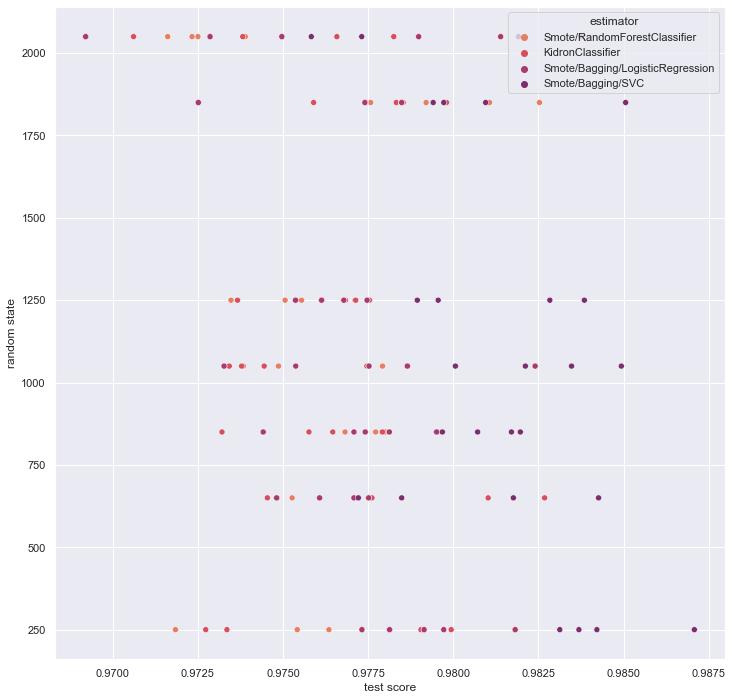

In [8]:
sns.set(rc = {"figure.figsize" : (12, 12)}) 
sns.scatterplot(data = f1, x = "test score", y = "random state", hue = "estimator", palette = "flare")

<AxesSubplot:xlabel='test score', ylabel='test size'>

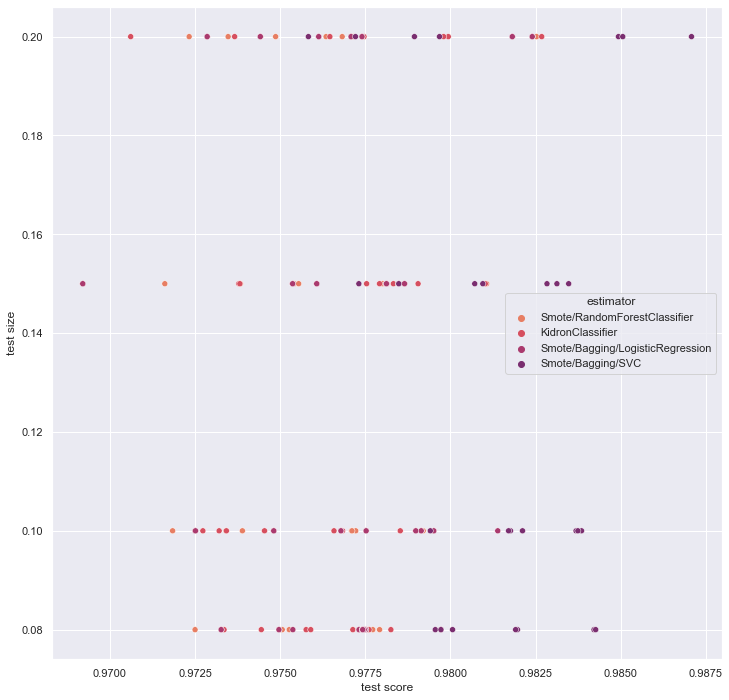

In [9]:
sns.set(rc = {"figure.figsize" : (12, 12)}) 
sns.scatterplot(data = f1, x = "test score", y = "test size", hue = "estimator", palette = "flare")

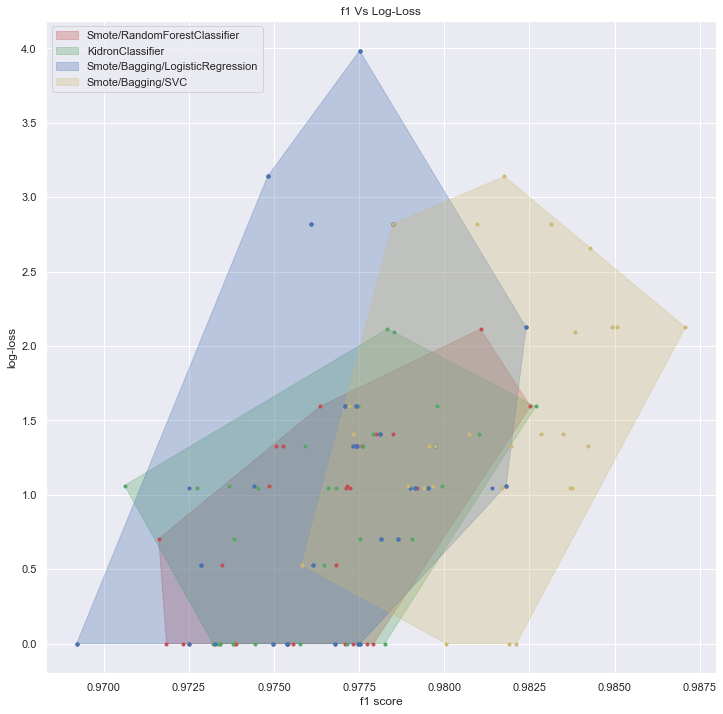

In [10]:
#overall scores
colors = ['r', 'g', 'b', 'y']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for k, estimator in enumerate(f1.estimator.unique()):
    data = f1[f1.estimator == estimator]    
    x = data["test score"].to_list()
    z = data["test log_loss"].to_list()
    points = np.transpose(np.array([x, z]))
    hull = ConvexHull(points)
    
    plt.plot(points[:,0], points[:,1], '.', color = colors[k])
    plt.fill(points[hull.vertices,0], points[hull.vertices, 1], color = colors[k], alpha = 0.3, label = estimator)

plt.title('f1 Vs Log-Loss')
plt.xlabel('f1 score')
plt.ylabel('log-loss')
plt.legend(loc = 2)
plt.show()

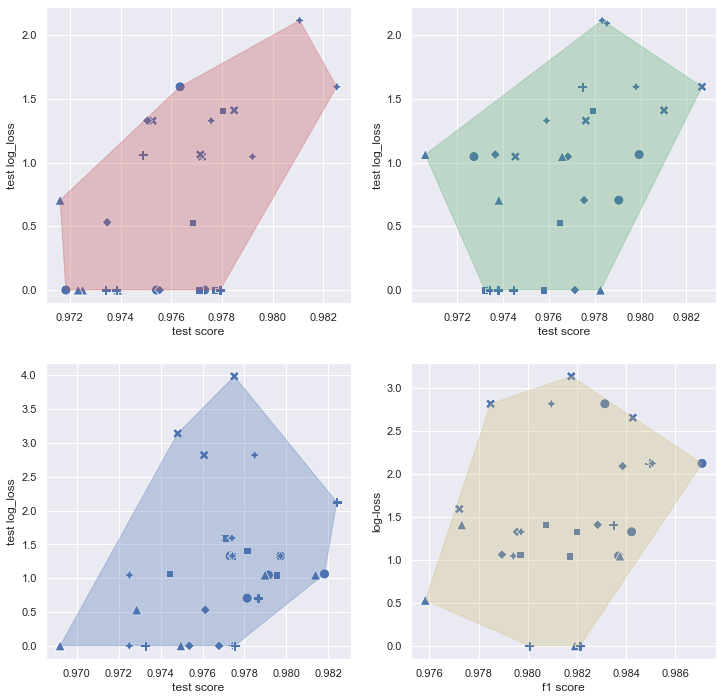

In [11]:
#how random state changes distribution
colors = ['r', 'g', 'b', 'y']
fig, axs = plt.subplots(2, 2)

for k, estimator in enumerate(f1.estimator.unique()):
    
    ax = axs[ k // 2, k % 2]
    data = f1[f1.estimator == estimator]    
    x = data["test score"].to_list()
    z = data["test log_loss"].to_list()
    
    sns.scatterplot(data = data, x = "test score", y = "test log_loss", s = 100, style = "random state", ax = ax)

    points = np.transpose(np.array([x, z]))
    hull = ConvexHull(points)
    ax.fill(points[hull.vertices,0], points[hull.vertices, 1], color = colors[k], alpha = 0.3)  
    ax.get_legend().remove()

#plt.title('f1 Vs Log-Loss')
plt.xlabel('f1 score')
plt.ylabel('log-loss')
#plt.legend(loc = 2)
plt.show()

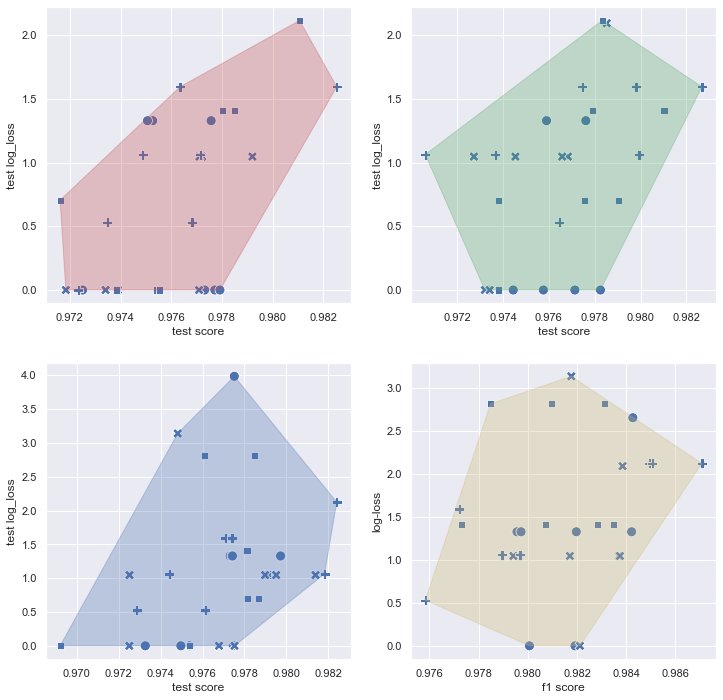

In [12]:
#how test size changes distribution
colors = ['r', 'g', 'b', 'y']
fig, axs = plt.subplots(2, 2)

for k, estimator in enumerate(f1.estimator.unique()):
    
    ax = axs[ k // 2, k % 2]
    data = f1[f1.estimator == estimator]    
    x = data["test score"].to_list()
    z = data["test log_loss"].to_list()
    
    sns.scatterplot(data = data, x = "test score", y = "test log_loss", s = 100, style = "test size", ax = ax)

    points = np.transpose(np.array([x, z]))
    hull = ConvexHull(points)
    ax.fill(points[hull.vertices,0], points[hull.vertices, 1], color = colors[k], alpha = 0.3)  
    ax.get_legend().remove()

#plt.title('f1 Vs Log-Loss')
plt.xlabel('f1 score')
plt.ylabel('log-loss')
#plt.legend(loc = 2)
plt.show()

In [13]:
m = f1[f1["test score"] == max(f1["test score"])]
m

,Unnamed: 0,score,test score,train score,test variance,train variance,test rmse,train rmse,test log_loss,train log_loss,test size,random state,estimator,estimator params
322,322,f1,0.98708,1.0,0.000268,0.0,0.248069,0.0,2.1255,9.992007e-16,0.2,250,Smote/Bagging/SVC,"False,True,2,1.0,linear,1"


In [14]:
f1_rf = f1[f1.estimator ==  'Smote/RandomForestClassifier']
m = f1_rf[f1_rf["test score"] == max(f1_rf["test score"])]
m

,Unnamed: 0,score,test score,train score,test variance,train variance,test rmse,train rmse,test log_loss,train log_loss,test size,random state,estimator,estimator params
52,52,f1,0.982531,0.992627,0.0001,0.000002,0.214834,0.08554,1.594097,0.252723,0.2,1850,Smote/RandomForestClassifier,"10,3"


In [15]:
testsize, randomstate = 0.2, 1850
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)
smote = SMOTE(random_state = randomstate)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)

X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
        
rf = RandomForestClassifier(max_depth =10, min_samples_leaf = 3, random_state = randomstate)
rf.fit(X_train, y_train)

rf_probs = rf.predict_proba(X_test)[:,  1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

In [40]:
f1_kc = f1[f1.estimator ==  'KidronClassifier']
m = f1_kc[f1_kc["test score"] == max(f1_kc["test score"])]
m

,Unnamed: 0,score,test score,train score,test variance,train variance,test rmse,train rmse,test log_loss,train log_loss,test size,random state,estimator,estimator params
100,100,f1,0.982682,0.974645,0.000341,0.000022,0.214834,0.196494,1.594097,1.333543,0.2,650,KidronClassifier,"12,DecisionTreeClassifier(),30,600"


In [37]:
testsize, randomstate = 0.2, 650
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)

X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
       
X_train = pd.DataFrame(robustscaler.transform(X_train))
X_test  = pd.DataFrame(robustscaler.transform(X_test))

kc = KidronClassifier(max_estimators = 12, base_estimator = DecisionTreeClassifier(), min_rows = 30, min_columns = 600, random_state = randomstate)
kc.fit(X_train, y_train)

kc_probs = rf.predict_proba(X_test)[:,  1]
kc_fpr, kc_tpr, _ = roc_curve(y_test, kc_probs)

In [41]:
f1_lr = f1[f1.estimator ==  'Smote/Bagging/LogisticRegression']
m = f1_lr[f1_lr["test score"] == max(f1_lr["test score"])]
m

,Unnamed: 0,score,test score,train score,test variance,train variance,test rmse,train rmse,test log_loss,train log_loss,test size,random state,estimator,estimator params
256,256,f1,0.982404,1.0,0.000104,0.0,0.248069,0.0,2.125475,9.992007e-16,0.2,1050,Smote/Bagging/LogisticRegression,"1.0,False,True,2,1.0"
258,258,f1,0.982404,1.0,0.000104,0.0,0.248069,0.0,2.125475,9.992007e-16,0.2,1050,Smote/Bagging/LogisticRegression,"1.0,False,True,2,1.0"
260,260,f1,0.982404,1.0,0.000104,0.0,0.248069,0.0,2.125475,9.992007e-16,0.2,1050,Smote/Bagging/LogisticRegression,"1.0,False,True,2,1.0"


In [17]:
testsize, randomstate = 0.2, 1050
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)
smote = SMOTE(random_state = randomstate)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)

X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
        
lr = LogisticRegression(C = 1, solver = 'liblinear', max_iter = 200, class_weight = 'balanced', random_state = randomstate)
bc = BaggingClassifier(base_estimator = lr, bootstrap = False, bootstrap_features = True, n_estimators = 2, max_samples = 1, n_jobs = jobs, random_state = randomstate)
bc.fit(X_train, y_train)

lr_probs = bc.predict_proba(X_test)[:,  1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

In [42]:
f1_svc = f1[f1.estimator ==  'Smote/Bagging/SVC']
m = f1_svc[f1_svc["test score"] == max(f1_svc["test score"])]
m

,Unnamed: 0,score,test score,train score,test variance,train variance,test rmse,train rmse,test log_loss,train log_loss,test size,random state,estimator,estimator params
322,322,f1,0.98708,1.0,0.000268,0.0,0.248069,0.0,2.1255,9.992007e-16,0.2,250,Smote/Bagging/SVC,"False,True,2,1.0,linear,1"


In [27]:
testsize, randomstate = 0.2, 250
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = randomstate)
smote = SMOTE(random_state = randomstate)
X_train, y_train = smote.fit_resample(X_train, y_train)

robustscaler = RobustScaler(quantile_range = (1, 99))
robustscaler.fit(X_train)

X_train = robustscaler.transform(X_train)
X_test  = robustscaler.transform(X_test)
        
svc = SVC(kernel = 'linear', C = 1, max_iter = 200, class_weight = 'balanced', random_state = randomstate)
bc = BaggingClassifier(base_estimator = svc, bootstrap = False, bootstrap_features = True, n_estimators = 2,  max_samples = 1.0, random_state = randomstate)
bc.fit(X_train, y_train)

svc_probs = bc.predict_proba(X_test)[:,  1]
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)

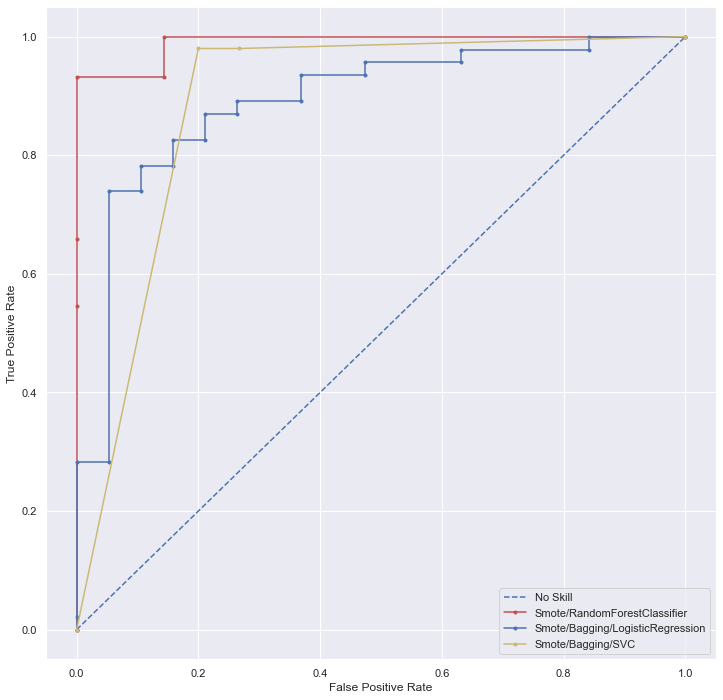

In [44]:
X_random, y_random = make_classification(n_samples = 1000, n_classes = 2, random_state = 1)
ns_probs = [0 for _ in range(len(y_random))]
ns_fpr, ns_tpr, _ = roc_curve(y_random, ns_probs)

pyplot.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'No Skill')

pyplot.plot(rf_fpr, rf_tpr, marker = '.', label = 'Smote/RandomForestClassifier', color = 'r')
#pyplot.plot(kc_fpr, kc_tpr, marker = '.', label = 'KidronClassifier')
pyplot.plot(lr_fpr, lr_tpr, marker = '.', label = 'Smote/Bagging/LogisticRegression', color = 'b')
pyplot.plot(svc_fpr, svc_tpr, marker = '.', label = 'Smote/Bagging/SVC', color = 'y')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()